In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/home/jiahao/code/SPH6004/assignment1_data.csv')

In [3]:
print(data.head())

   subject_id   hadm_id   stay_id gender  dod            admittime  \
0    10018501  28479513  34739077      M  NaN  2141-07-30 22:34:00   
1    11424857  22010683  33113817      M  NaN  2155-06-03 18:10:00   
2    11797249  29600029  34926613      F  NaN  2159-11-02 09:24:00   
3    12196836  21710144  31460719      M  NaN  2121-02-18 02:41:00   
4    12242414  26119789  30542485      M  NaN  2140-11-09 00:00:00   

             dischtime  los_hospital  admission_age               ethnicity  \
0  2141-08-05 18:06:00      5.813889             83                   WHITE   
1  2155-06-21 12:58:00     17.783333             51                   WHITE   
2  2159-11-09 15:45:00      7.264583             36  BLACK/AFRICAN AMERICAN   
3  2121-02-22 17:15:00      4.606944             56                   WHITE   
4  2140-11-13 16:45:00      4.697917             73                   WHITE   

   ...  ck_cpk_min  ck_cpk_max  ck_mb_min ck_mb_max ggt_min  ggt_max  \
0  ...       124.0       124.0  

In [4]:
new_data = data.drop(['subject_id','hadm_id','stay_id',
                    'dod','admittime','dischtime','icu_intime','icu_outtime'
                     ,'subject_id-2','hadm_id-2','subject_id-3','stay_id-2',
                     'subject_id-4','stay_id-3',],axis=1)

In [5]:
y = new_data.pop(new_data.columns[4])

In [6]:
non_numerical = new_data.select_dtypes(exclude=['int64','float64']).columns.values

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for name in non_numerical:
    le.fit(new_data[name])
    new_data[name] = le.transform(new_data[name])

In [8]:
from sklearn.impute import SimpleImputer
import numpy as np
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp_mean.fit_transform(new_data)
y = y.to_numpy()

In [9]:
print(X.shape)

(50048, 132)


In [10]:
from sklearn import preprocessing
X_norm = preprocessing.scale(X)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle')
X_PCA = pca.fit_transform(X_norm)
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.2, random_state=0)

In [ ]:
# visulization
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
tsne = TSNE(n_jobs=4)
X_tsne = tsne.fit_transform(X_norm)


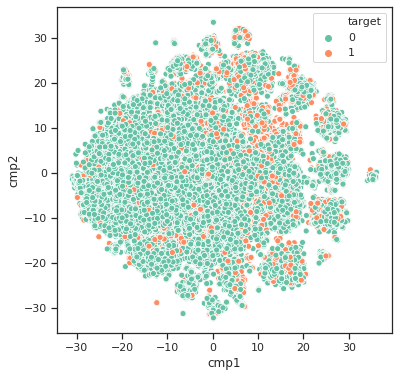

In [46]:
import pandas
data_frame_rd = pandas.DataFrame(data=X_tsne,columns=['cmp1','cmp2'])
data_frame_rd['target'] = y
fig = plt.figure(figsize=(6,6))
sns.set_context("paper")
sns.set(font_scale=1)
sns.set_style("ticks")
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="cmp1", y="cmp2", data=data_frame_rd,hue="target",
                     hue_norm=(0, 1),
                     palette="Set2",legend='brief')
# plt.savefig('data_vis_0118-6.png',dpi=300)

In [12]:
print(X_train.shape)
print(y_train.shape)

(40038, 132)
(40038,)


In [49]:
## logistic regression without feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(penalty='none',solver='newton-cg',random_state=0).fit(X_train, y_train)
acc_non = clf.score(X_test, y_test)
auroc_non = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(acc_non)
print(auroc_non)
## l1 penalty
clf = LogisticRegression(penalty='l1',solver='liblinear',random_state=0).fit(X_train, y_train)
acc_l1 = clf.score(X_test, y_test)
auroc_l1 = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(acc_l1)
print(auroc_l1)
## l2 penalty
clf = LogisticRegression(penalty='l2',solver='newton-cg',random_state=0).fit(X_train, y_train)
acc_l2 = clf.score(X_test, y_test)
auroc_l2 = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(acc_l2)
print(auroc_l2)

0.9185814185814186
0.8819957160185551
0.9184815184815185
0.8820216104390107
0.9183816183816184
0.8820370618421632


In [45]:
l2=[0.5,1,2,3]
acc = []
auroc =[]
for c in l2:
    
    clf = LogisticRegression(penalty='l2',solver='newton-cg',C=c,random_state=0).fit(X_train, y_train)
    acc_l2 = clf.score(X_test, y_test)
    auroc_l2 = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    acc.append(acc_l2)
    auroc.append(auroc_l2)

In [72]:
# lr
clf = LogisticRegression(penalty='l2',solver='newton-cg',random_state=0)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
print('Training accuracy on ALL features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('Testing accuracy on ALL features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.919
training auroc:0.883
Testing accuracy on selected features: 0.918
testing auroc:0.882


In [98]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)

In [99]:
X_new = model.transform(X_train)

In [101]:
# lr
clf = LogisticRegression(penalty='l2',solver='newton-cg',random_state=0)
clf.fit(X_new, y_train)
y_train_pred = clf.predict(X_new)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_new)[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
X_test_new = model.transform(X_test)
y_test_pred = clf.predict(X_test_new)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test_new)[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.919
training auroc:0.882
Testing accuracy on selected features: 0.919
testing auroc:0.882


In [126]:
## with feature selection for logistic regression
#1 step_wise
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from time import time
clf = LogisticRegression(penalty='l2',solver='newton-cg',random_state=0)
tic = time()

sfs1 = sfs(clf,
           k_features=int(0.8*X_train.shape[1]),
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           n_jobs=4,
           cv=5)


# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)
toc = time()
print(f"Done in {toc - tic:.3f}s")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 128 out of 128 | elapsed:   13.6s finished

[2021-02-28 19:33:18] Features: 1/102 -- score: 0.9016684951117323[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 127 out of 127 | elapsed:   17.6s finished

[2021-02-28 19:33:36] Features: 2/102 -- score: 0.9033918342179863[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 126 out of 126 | elapsed:   19.8s finished

[2021-02-28 19:33:56] Features: 3/102 -- score: 0.9048904636015914[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | e

Done in 8211.601s


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  1.6min finished

[2021-02-28 21:49:56] Features: 102/102 -- score: 0.9195014489694145

In [127]:
from sklearn.metrics import accuracy_score as acc
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
clf.fit(X_train[:, feat_cols], y_train)
y_train_pred = clf.predict(X_train[:, feat_cols])
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train[:, feat_cols])[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test[:, feat_cols])
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test[:, feat_cols])[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

[0, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 27, 29, 31, 32, 33, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 56, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127]
Training accuracy on selected features: 0.921
training auroc:0.855
Testing accuracy on selected features: 0.919
testing auroc:0.853


In [105]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0,max_depth=5)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
print('Training accuracy on ALL features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('Testing accuracy on ALL features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.910
training auroc:0.797
Testing accuracy on selected features: 0.903
testing auroc:0.798


In [106]:
clf = DecisionTreeClassifier(random_state=0,max_depth=5)
clf.fit(X_new, y_train)
y_train_pred = clf.predict(X_new)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_new)[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
X_test_new = model.transform(X_test)
y_test_pred = clf.predict(X_test_new)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test_new)[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.910
training auroc:0.799
Testing accuracy on selected features: 0.904
testing auroc:0.801


In [60]:
from sklearn.metrics import accuracy_score as acc
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
clf.fit(X_train[:, feat_cols], y_train)
y_train_pred = clf.predict(X_train[:, feat_cols])
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train[:, feat_cols])[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test[:, feat_cols])
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test[:, feat_cols])[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

[0, 2, 5, 8, 11, 13, 14, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 33, 35, 36, 37, 38, 41, 43, 44, 45, 46, 47, 51, 53, 58, 62, 63, 65, 74, 76, 77, 78, 79, 81, 84, 85, 86, 87, 92, 93, 94, 97, 101, 102, 108, 112, 113, 118, 119, 120, 123, 124, 127]
Training accuracy on selected features: 0.910
training auroc:0.777
Testing accuracy on selected features: 0.903
testing auroc:0.777


In [61]:
# random forest 
from sklearn.metrics import accuracy_score as acc
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50,max_depth=20, random_state=0,n_jobs=4)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
print('Training accuracy on ALL features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('Testing accuracy on ALL features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.972
training auroc:0.994
Testing accuracy on selected features: 0.913
testing auroc:0.882


In [109]:
clf = RandomForestClassifier(n_estimators=50,max_depth=20, random_state=0,n_jobs=4)
clf.fit(X_new, y_train)
y_train_pred = clf.predict(X_new)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_new)[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
X_test_new = model.transform(X_test)
y_test_pred = clf.predict(X_test_new)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test_new)[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.973
training auroc:0.995
Testing accuracy on selected features: 0.912
testing auroc:0.885


In [65]:
from sklearn.metrics import accuracy_score as acc
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
clf.fit(X_train[:, feat_cols], y_train)
y_train_pred = clf.predict(X_train[:, feat_cols])
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train[:, feat_cols])[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test[:, feat_cols])
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test[:, feat_cols])[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

[0, 2, 5, 8, 11, 13, 14, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 33, 35, 36, 37, 38, 41, 43, 44, 45, 46, 47, 51, 53, 58, 62, 63, 65, 74, 76, 77, 78, 79, 81, 84, 85, 86, 87, 92, 93, 94, 97, 101, 102, 108, 112, 113, 118, 119, 120, 123, 124, 127]
Training accuracy on selected features: 0.966
training auroc:0.992
Testing accuracy on selected features: 0.910
testing auroc:0.849


In [66]:
# adaboost and gradient boost
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
print('Training accuracy on all features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('Testing accuracy on all features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.922
training auroc:0.896
Testing accuracy on selected features: 0.914
testing auroc:0.881


In [111]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)
clf.fit(X_new,y_train)
y_train_pred = clf.predict(X_new)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_new)[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
X_test_new = model.transform(X_test)
y_test_pred = clf.predict(X_test_new)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test_new)[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.922
training auroc:0.896
Testing accuracy on selected features: 0.915
testing auroc:0.880


In [67]:
from sklearn.metrics import accuracy_score as acc
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
clf.fit(X_train[:, feat_cols], y_train)
y_train_pred = clf.predict(X_train[:, feat_cols])
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train[:, feat_cols])[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test[:, feat_cols])
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test[:, feat_cols])[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

[0, 2, 5, 8, 11, 13, 14, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 33, 35, 36, 37, 38, 41, 43, 44, 45, 46, 47, 51, 53, 58, 62, 63, 65, 74, 76, 77, 78, 79, 81, 84, 85, 86, 87, 92, 93, 94, 97, 101, 102, 108, 112, 113, 118, 119, 120, 123, 124, 127]
Training accuracy on selected features: 0.913
training auroc:0.863
Testing accuracy on selected features: 0.908
testing auroc:0.845


In [71]:
# adaboost and gradient boost
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=150, random_state=0).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
print('Training accuracy on all features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('Testing accuracy on all features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.920
training auroc:0.914
Testing accuracy on selected features: 0.915
testing auroc:0.889


In [112]:
clf = AdaBoostClassifier(n_estimators=150, random_state=0)
clf.fit(X_new,y_train)
y_train_pred = clf.predict(X_new)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_new)[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
X_test_new = model.transform(X_test)
y_test_pred = clf.predict(X_test_new)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test_new)[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.920
training auroc:0.913
Testing accuracy on selected features: 0.917
testing auroc:0.890


In [ ]:
from sklearn.metrics import accuracy_score as acc
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
clf.fit(X_train[:, feat_cols], y_train)
y_train_pred = clf.predict(X_train[:, feat_cols])
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train[:, feat_cols])[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test[:, feat_cols])
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test[:, feat_cols])[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

In [113]:
# svm
from sklearn import svm
clf = svm.SVC(probability=True,random_state=0).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.949
training auroc:0.958
Testing accuracy on selected features: 0.923
testing auroc:0.911


In [115]:
clf = svm.SVC(probability=True,random_state=0).fit(X_train, y_train)
clf.fit(X_new,y_train)
y_train_pred = clf.predict(X_new)
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_new)[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
X_test_new = model.transform(X_test)
y_test_pred = clf.predict(X_test_new)
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test_new)[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

Training accuracy on selected features: 0.948
training auroc:0.957
Testing accuracy on selected features: 0.923
testing auroc:0.910


In [57]:
from sklearn.metrics import accuracy_score as acc
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
clf.fit(X_train[:, feat_cols], y_train)
y_train_pred = clf.predict(X_train[:, feat_cols])
auroc_train = roc_auc_score(y_train, clf.predict_proba(X_train[:, feat_cols])[:,1])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
print('training auroc:%.3f' % auroc_train)
y_test_pred = clf.predict(X_test[:, feat_cols])
auroc_test= roc_auc_score(y_test, clf.predict_proba(X_test[:, feat_cols])[:,1])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))
print('testing auroc:%.3f' % auroc_test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 15, 16, 17, 18, 20, 25, 26, 29, 31, 33, 36, 39, 40, 42, 44, 45, 46, 48, 49, 50, 51, 52, 54, 56, 62, 63, 64, 65, 66, 73, 75, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 100, 101, 102, 108, 112, 115, 116, 117, 118, 124, 125, 126, 127, 128, 129, 130, 131]


/home/jiahao/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training accuracy on selected features: 0.939
Testing accuracy on selected features: 0.920


In [122]:
## simple nn
import torch
import torch.nn as nn
model = torch.nn.Sequential(
#             nn.Dropout(0.5),
            nn.Linear(97,64),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64,64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64,2),
)
X_tensor = torch.FloatTensor(X_new).cuda()
y_tensor = torch.tensor(y_train).cuda()
X_test_tensor = torch.FloatTensor(X_test_new).cuda()
y_test_tensor = torch.tensor(y_test).cuda()
model.cuda()

Sequential(
  (0): Linear(in_features=97, out_features=64, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=64, out_features=2, bias=True)
)

In [123]:
FF = torch.nn.Softmax(dim=1)
lr = 1e-1 # 0.1
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=100)
acc_best = 0
correct = 0
total = 0
total_epoch = 10000

In [124]:
for epoch in range(total_epoch):
    model.train()
    train_logits = model(X_tensor)
    loss = criterion(train_logits,y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    result = FF(train_logits)
    _,predicted = torch.max(result.data,1)
    total += y_tensor.size(0)
    correct += (predicted==y_tensor).sum().item() 
    train_acc = correct/total
    
    model.eval()
    
    test_logits = model(X_test_tensor)
    test_loss = criterion(test_logits,y_test_tensor)
    outputs = FF(test_logits)
            
    _, predicted = torch.max(outputs.data, 1)
    total += y_test_tensor.size(0)
    correct += (predicted == y_test_tensor).sum().item()
    test_acc = correct/total
    scheduler.step(test_loss)
    if (epoch+1) % 50 == 0:
        print("Epoch [%d/%d],  train_Loss: %.4f test_Loss: %.4f train_Acc: %d %% test_Acc: %d %%" %
                          (epoch+1, total_epoch,
                           loss.data.item(),test_loss.data.item(),
                           100*float(train_acc),100*float(test_acc)))

Epoch [50/10000],  train_Loss: 0.3319 test_Loss: 0.3151 train_Acc: 88 % test_Acc: 88 %
Epoch [100/10000],  train_Loss: 0.2932 test_Loss: 0.2732 train_Acc: 89 % test_Acc: 89 %
Epoch [150/10000],  train_Loss: 0.2728 test_Loss: 0.2538 train_Acc: 89 % test_Acc: 89 %
Epoch [200/10000],  train_Loss: 0.2646 test_Loss: 0.2435 train_Acc: 89 % test_Acc: 89 %
Epoch [250/10000],  train_Loss: 0.2562 test_Loss: 0.2369 train_Acc: 89 % test_Acc: 89 %
Epoch [300/10000],  train_Loss: 0.2498 test_Loss: 0.2321 train_Acc: 89 % test_Acc: 89 %
Epoch [350/10000],  train_Loss: 0.2479 test_Loss: 0.2283 train_Acc: 90 % test_Acc: 90 %
Epoch [400/10000],  train_Loss: 0.2444 test_Loss: 0.2253 train_Acc: 90 % test_Acc: 90 %
Epoch [450/10000],  train_Loss: 0.2395 test_Loss: 0.2228 train_Acc: 90 % test_Acc: 90 %
Epoch [500/10000],  train_Loss: 0.2369 test_Loss: 0.2207 train_Acc: 90 % test_Acc: 90 %
Epoch [550/10000],  train_Loss: 0.2357 test_Loss: 0.2187 train_Acc: 90 % test_Acc: 90 %
Epoch [600/10000],  train_Loss: 0

In [125]:
print(test_acc)
auroc_test= roc_auc_score(y_test, outputs[:,1].data.cpu())

print('testing auroc:%.3f' % auroc_test)

0.9327690297314578
testing auroc:0.946
